In [1]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
!pip install huggingface_hub==0.8.1

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-jnw7xn33
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-jnw7xn33
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9106 sha256=8a58d30675984c6f425b95ab73fc2d590f16ca403032c15309e0bc6fd94b2166
  Stored in directory: /tmp/pip-ephem-wheel-cache-7wpw7cer/wheels/dd/a3/7d/774508ed192455403be294c8a6c4ad1c83dde8fcdd8903e64a
Successfully built RealESRGAN
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2
ERROR: pip's dependency resolver does not currentl

# Import Libraries

In [2]:
# Standard Libraries  
import os   
import numpy as np  
import pandas as pd  

# Visualization Libraries  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Progress Tracking  
from tqdm.notebook import tqdm   

# Image Processing Libraries  
import cv2  
from PIL import Image    
from torchvision.transforms.functional import to_pil_image   

# Super-Resolution (GAN-based) Library  
import torch   
from RealESRGAN import RealESRGAN  # Real-ESRGAN model for image super-resolution  

# Deep Learning Libraries  
import tensorflow as tf   
from tensorflow.keras import layers, models  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation  
import keras  

# Hyperparameter Tuning Library  
import keras_tuner as kt  

# Machine Learning Utilities  
from sklearn.model_selection import train_test_split   
from sklearn.metrics import classification_report, confusion_matrix  

/opt/conda/lib/python3.10/site-packages/RealESRGAN/model.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Datasets

## Joining Directories

In [4]:
# Directories for the dataset
train_dir = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train'
test_dir = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test'

# Create separate directories for benign and malignant
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')

test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')

## Preprocess

### Adaptive Gamma Correction

Improves image brightness adaptively without overexposure by normalizing pixel values, calculating the mean luminance, adjusting gamma based on it, and then applying the correction.

In [5]:
def adaptive_gamma_correction(image, gamma=0.7):
    img_float = image.astype(np.float32) / 255.0
    mean_luminance = np.mean(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)) / 255.0
    gamma_corrected = np.power(img_float, gamma / mean_luminance)
    return np.clip(gamma_corrected * 255, 0, 255).astype(np.uint8)

### Hair Removal
Removes hair or unwanted features by detecting and inpainting using morphological operations. Grayscale conversion, blackhat morphological operation, thresholding, and inpainting are applied to remove unwanted features.

In [6]:
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Smaller kernel size
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted

### Real ESRGAN

This section sets up the Real-ESRGAN model for image upscaling with a specified factor.

- **Model Setup**:  
  The Real-ESRGAN model is initialized with a scale factor (e.g., 2x upscaling).

- **Loading Weights**:  
  Pre-trained model weights are loaded from the specified path for the selected scale factor.

- **Upscaling Function**:  
  The `upscale_with_gan` function takes an image, converts it to PIL format, uses the model to upscale the image, and then returns the upscaled image in NumPy array format.

In [7]:
# Set up Real-ESRGAN model
factor = 2
model = RealESRGAN(device, scale=factor)

In [8]:
# Load model weights
model_path = f'/kaggle/input/real-esrgan-weights/RealESRGAN_weights/RealESRGAN_x{factor}.pth'
model.load_weights(model_path)

/opt/conda/lib/python3.10/site-packages/RealESRGAN/model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)


In [9]:
def upscale_with_gan(image):
    pil_image = Image.fromarray(image)
    with torch.no_grad():
        upscaled_image = model.predict(pil_image)
    return np.array(upscaled_image)

### Combine Steps

The function enhances image quality by first removing hair artifacts, then adjusting brightness using adaptive gamma correction. It upscales the image using a GAN-based model for better resolution and finally resizes it to a fixed dimension for consistency in training.

In [10]:
# Combine selected preprocessing steps
def preprocess_image(image):
    image = remove_hair(image)
    image = adaptive_gamma_correction(image)
    image = upscale_with_gan(image)  
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)  
    return image

## Load Train-Test Datasets

**Creating Temporary Storage**  
A directory is set up to store preprocessed images, ensuring the processed versions are available for later use. The `os.makedirs` function creates the directory if it does not already exist.  

**Loading and Filtering Images**  
The function retrieves image files from the specified directory, filtering only `.jpg` and `.png` formats. An optional limit is applied to restrict the number of images processed, which is useful for debugging and quick testing.  

**Preprocessing Steps**  
Each image is read using OpenCV and converted to the RGB color format. The image is then resized to `128x128` pixels for consistency. After resizing, it undergoes multiple preprocessing steps:   

**Saving Processed Images**  
After preprocessing, each image is converted back to the BGR format and saved in a temporary directory. The function records the file paths of the processed images along with their corresponding labels. Additionally, it stores both the original and processed images in separate lists, which can be used for comparison or visualization.  


In [11]:
TEMP_DIR = "/kaggle/working/preprocessed"
os.makedirs(TEMP_DIR, exist_ok=True)  

def load_data(directory, label, limit=None):
    file_paths = []
    labels = []
    images_before = []  # Store original images
    images_after = []   # Store processed images
    
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
    
    if limit:
        filenames = filenames[:limit]  # Limit processing for debugging
    
    print(f"Processing {len(filenames)} images from {directory}...")

    for filename in tqdm(filenames, desc="Processing images"):
        file_path = os.path.join(directory, filename)
        
        # Load original image
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        images_before.append(image)  

        # Resize and preprocess
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)  
        image = preprocess_image(image)  # Apply custom preprocessing
        images_after.append(image)  # Store processed image

        # Save the processed image in Kaggle's working directory
        temp_path = os.path.join(TEMP_DIR, filename)
        cv2.imwrite(temp_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  

        file_paths.append(temp_path)  # Store processed file path
        labels.append(label)

    return file_paths, labels, images_before, images_after

In [12]:
(
    train_benign_paths, train_benign_labels, 
    train_benign_images_before, train_benign_images_after
) = load_data(train_benign_dir, 'benign')

Processing 5000 images from /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign...


Processing images:   0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
(
    train_malignant_paths, train_malignant_labels, 
    train_malignant_images_before, train_malignant_images_after
) = load_data(train_malignant_dir, 'malignant')

Processing 4605 images from /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/malignant...


Processing images:   0%|          | 0/4605 [00:00<?, ?it/s]

In [14]:
(
    test_benign_paths, test_benign_labels, 
    test_benign_images_before, test_benign_images_after
) = load_data(test_benign_dir, 'benign')

Processing 500 images from /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign...


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
(
    test_malignant_paths, test_malignant_labels, 
    test_malignant_images_before, test_malignant_images_after
) = load_data(test_malignant_dir, 'malignant')

Processing 500 images from /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/malignant...


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

## Visualize Preprocessed Images

This function displays a side-by-side comparison of original and preprocessed images. It selects a limited number of samples and arranges them in a grid where each row contains an original image on the left and its processed version on the right. 

In [16]:
def visualize_images(original, processed, num_samples=5):
    """ Display images before and after preprocessing side by side. """
    num_samples = min(num_samples, len(original))  
    plt.figure(figsize=(10, num_samples * 2))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original[i])
        plt.title("Original Image")
        plt.axis("off")

        # Preprocessed image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(processed[i])
        plt.title("Preprocessed Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

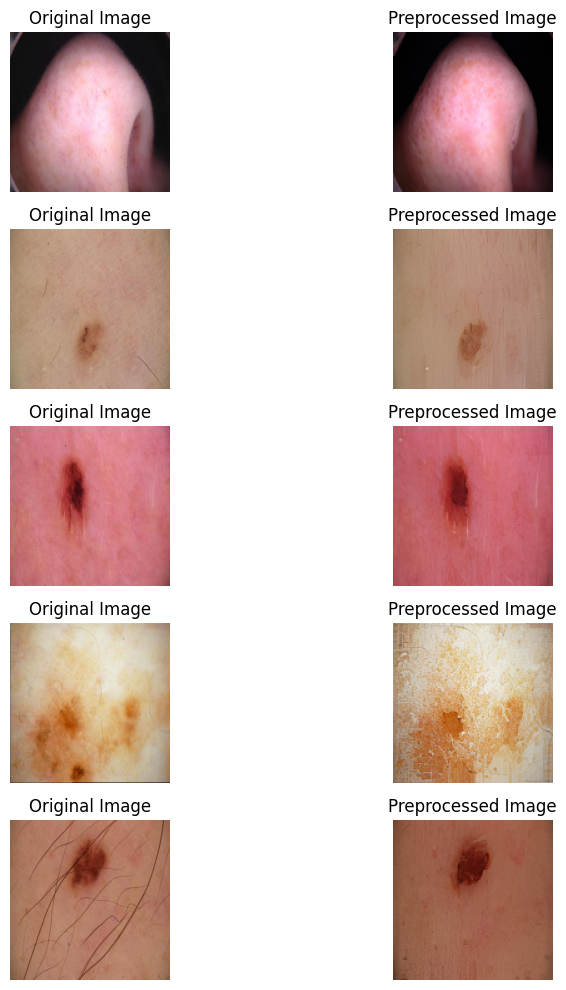

In [17]:
visualize_images(train_benign_images_before, train_benign_images_after)

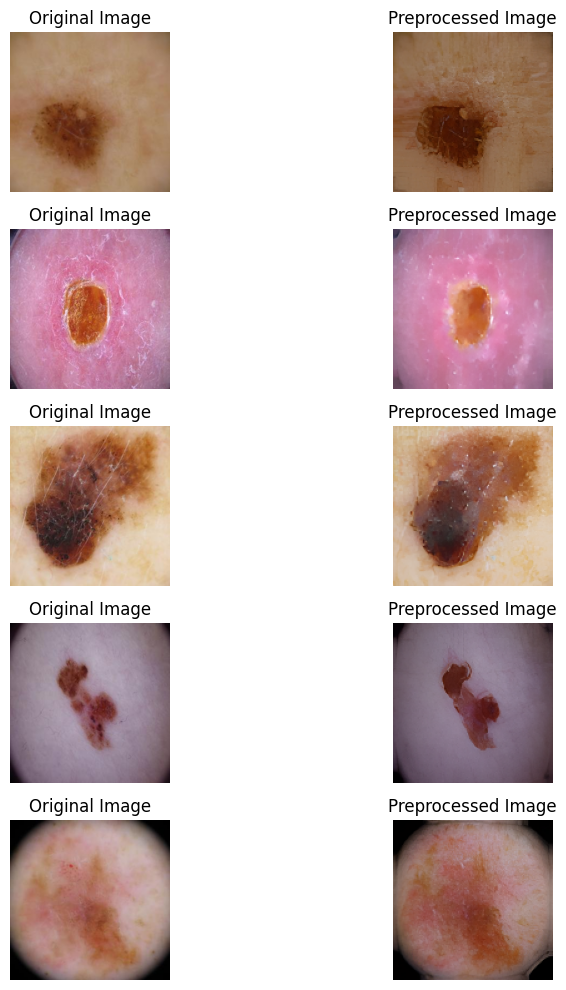

In [18]:
visualize_images(train_malignant_images_before, train_malignant_images_after)

**Preprocessing Results**  


Color consistency improves due to adaptive gamma correction, while upscaling and resizing introduce some smoothing or blurring. Hair removal is effective. The preprocessing standardizes images for machine learning, but potential fine detail loss from smoothing should be considered.  

# Creating Dataframe

The training and test datasets are organized into Pandas DataFrames, where each row contains the file path of a preprocessed image and its corresponding label. This structure simplifies data handling for model training and evaluation. 

In [19]:
# Combine and create DataFrames
train_df = pd.DataFrame({
    'file_path': train_benign_paths + train_malignant_paths,
    'label': train_benign_labels + train_malignant_labels
})

test_df = pd.DataFrame({
    'file_path': test_benign_paths + test_malignant_paths,
    'label': test_benign_labels + test_malignant_labels
})

In [20]:
train_df.head()

,file_path,label
0,/kaggle/working/preprocessed/melanoma_4922.jpg,benign
1,/kaggle/working/preprocessed/melanoma_3160.jpg,benign
2,/kaggle/working/preprocessed/melanoma_2315.jpg,benign
3,/kaggle/working/preprocessed/melanoma_1021.jpg,benign
4,/kaggle/working/preprocessed/melanoma_1352.jpg,benign


In [21]:
test_df.head()

,file_path,label
0,/kaggle/working/preprocessed/melanoma_9697.jpg,benign
1,/kaggle/working/preprocessed/melanoma_10087.jpg,benign
2,/kaggle/working/preprocessed/melanoma_9618.jpg,benign
3,/kaggle/working/preprocessed/melanoma_9614.jpg,benign
4,/kaggle/working/preprocessed/melanoma_9862.jpg,benign


# Splitting Training Dataset

The training dataset is split into training and validation subsets using an 80-20 ratio. Stratified sampling ensures that both subsets maintain the same label distribution as the original dataset.

In [22]:
# Split the training data into training and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Augmentation

In [23]:
image_size = (128, 128)
batch_size = 32

## Image Augmentation Setup


The `ImageDataGenerator` is configured to apply various transformations to the images during training. These include rescaling pixel values to the range [0, 1], and applying random transformations like rotation, shifting, shearing, zooming, and horizontal flipping.

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [25]:
train_datagen_no_aug = ImageDataGenerator(rescale=1.0/255)

In [26]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

## Data Generators Setup

The code sets up several data generators for different purposes:

- **Train Generator**: Applies the image augmentation transformations to the training data, which includes random rotations, shifts, shears, zooms, and flips. It reads image paths and labels from the `train_df` DataFrame, resizes them to the target size, and uses binary classification for the labels.

- **Train Generator without Augmentation**: A version of the train generator with no augmentation transformations applied. This is useful for baseline training without data augmentation.

- **Validation Generator**: Similar to the train generator, but for the validation set. It also resizes images and prepares them for binary classification. No augmentation is applied to the validation data to maintain consistency.

- **Test Generator**: This generator is for testing purposes. It reads the test data and applies no augmentation or shuffling to ensure that the model is evaluated in the same way as during training.


In [27]:
# Data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

train_generator_no_aug = train_datagen_no_aug.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 7684 validated image filenames belonging to 2 classes.
Found 7684 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


# Display Training Samples

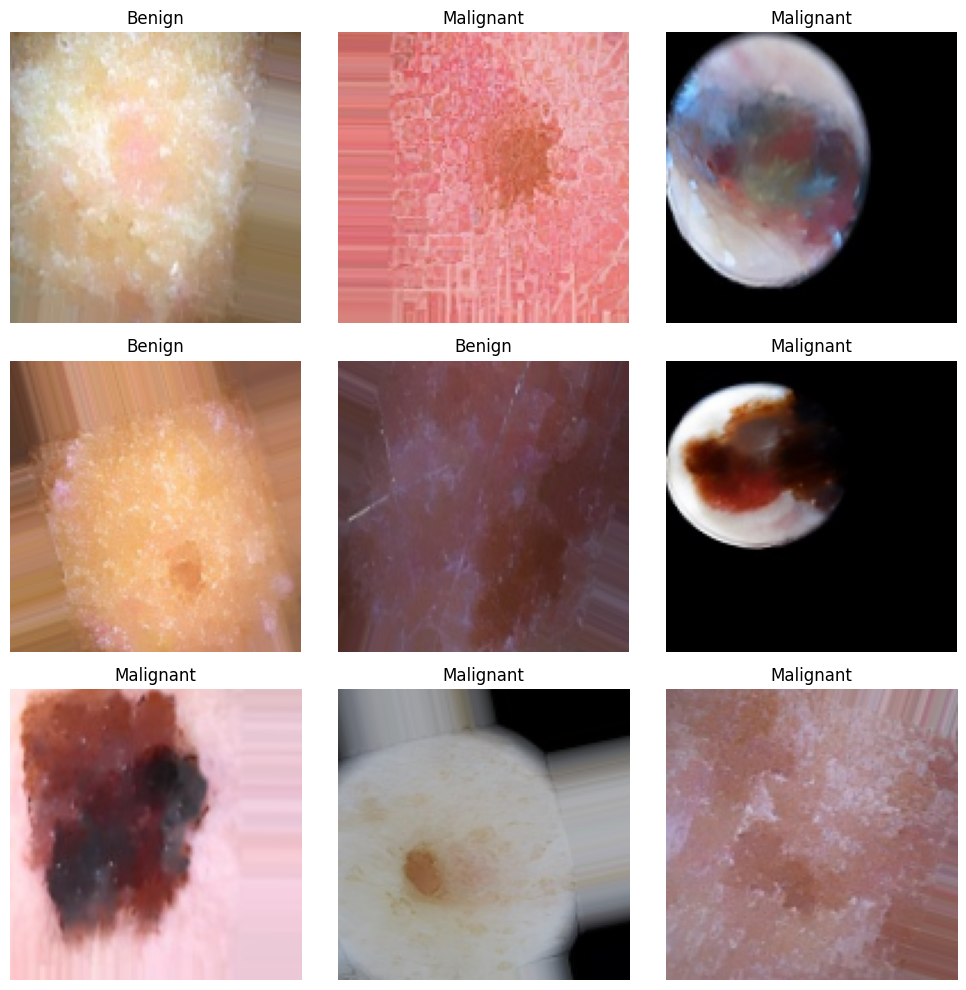

In [28]:
# Visualize some training samples 
sample_batch = next(train_generator)
images, labels = sample_batch

num_images = min(len(images), 9)  
grid_size = int(np.ceil(np.sqrt(num_images)))  

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(images[i])
    plt.title("Malignant" if labels[i] == 1 else "Benign")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Neural Network

## Training Setup

Adam optimizer, binary cross-entropy loss, accuracy metric, 5 initial epochs, and 20 final epochs.

In [29]:
OPTIMIZER = "adam"
LOSS_FUNC = "binary_crossentropy"
METRICS = ["accuracy"]
EPOCHS = 5
EPOCHS_FINAL = 20

## Tuning Results Function 

This function displays the tuning results of hyperparameter optimization, focusing on a specified parameter (e.g., "num_conv_layers"). It aggregates validation accuracies based on the parameter values, calculates the average accuracy for each parameter value, and prints the results along with individual accuracies from multiple trials.


In [30]:
from collections import defaultdict

# Function to display tuning results 
def print_tuning_results(tuner, param_name="num_conv_layers"):
    trials = tuner.oracle.trials
    param_results = defaultdict(list)  

    # Collect results
    for trial_id, trial in trials.items():
        param_value = trial.hyperparameters.get(param_name)
        val_accuracy = trial.metrics.get_best_value("val_accuracy")  
        if param_value is not None and val_accuracy is not None:
            param_results[param_value].append(val_accuracy)

    # Print results grouped by parameter values
    print(f"\nAll Tuning Results for '{param_name}':")
    print("=" * 60)
    for param_value, accuracies in sorted(param_results.items()):
        avg_acc = sum(accuracies) / len(accuracies)  
        print(f"{param_name}={param_value}: {len(accuracies)} trials, Avg val_accuracy={avg_acc:.4f}")
        print(f"  Individual accuracies: {', '.join(f'{acc:.4f}' for acc in accuracies)}\n")

## Custom Model

### Hyperparameter Tuning

#### Number of Convolution Layers

The `build_custom_cnn_conv_layers` function creates a CNN with a tunable number of convolutional layers, optimized for validation accuracy using Keras Tuner. 

The `tuner_custom_conv` searches for the best number of convolutional layers, aiming to maximize validation accuracy, and prints the results after the search.


In [31]:
def build_custom_cnn_conv_layers(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    num_conv_layers = hp.Int("num_conv_layers", min_value=2, max_value=5, step=1)
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters=32 * (2**i), kernel_size=3, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_custom_conv = kt.Hyperband(build_custom_cnn_conv_layers,
                                 objective="val_accuracy",
                                 max_epochs=EPOCHS,
                                 directory="tuner_logs/custom_cnn",
                                 project_name="conv_tuning")

tuner_custom_conv.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_custom_conv = tuner_custom_conv.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_conv_layers for Custom CNN: {best_hps_custom_conv.get('num_conv_layers')}")

print_tuning_results(tuner_custom_conv, param_name="num_conv_layers")

Trial 4 Complete [00h 01m 05s]
val_accuracy: 0.8287350535392761

Best val_accuracy So Far: 0.8771473169326782
Total elapsed time: 00h 04m 23s
Best num_conv_layers for Custom CNN: 3

All Tuning Results for 'num_conv_layers':
num_conv_layers=2: 1 trials, Avg val_accuracy=0.8725
  Individual accuracies: 0.8725

num_conv_layers=3: 1 trials, Avg val_accuracy=0.8771
  Individual accuracies: 0.8771

num_conv_layers=4: 1 trials, Avg val_accuracy=0.8287
  Individual accuracies: 0.8287

num_conv_layers=5: 1 trials, Avg val_accuracy=0.8579
  Individual accuracies: 0.8579



#### Number of Filters

The `build_custom_cnn_filters` function builds a CNN with a tunable number of filters, optimizing for validation accuracy based on the best number of convolutional layers found previously. The `tuner_custom_filters` searches for the best number of filters to maximize validation accuracy, and after the search, the results are displayed, including the best number of filters found for the model.

In [32]:
def build_custom_cnn_filters(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    num_conv_layers = best_hps_custom_conv.get("num_conv_layers")
    num_filters = hp.Choice("num_filters", values=[16, 32, 64, 128])

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters * (2**i), kernel_size=3, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_custom_filters = kt.Hyperband(build_custom_cnn_filters,
                                    objective="val_accuracy",
                                    max_epochs=EPOCHS,
                                    directory="tuner_logs/custom_cnn",
                                    project_name="filters_tuning")

tuner_custom_filters.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_custom_filters = tuner_custom_filters.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_filters for Custom CNN: {best_hps_custom_filters.get('num_filters')}")

print_tuning_results(tuner_custom_filters, param_name="num_filters")

Trial 4 Complete [00h 01m 10s]
val_accuracy: 0.8750650882720947

Best val_accuracy So Far: 0.8787090182304382
Total elapsed time: 00h 04m 26s
Best num_filters for Custom CNN: 16

All Tuning Results for 'num_filters':
num_filters=16: 1 trials, Avg val_accuracy=0.8787
  Individual accuracies: 0.8787

num_filters=32: 1 trials, Avg val_accuracy=0.8350
  Individual accuracies: 0.8350

num_filters=64: 1 trials, Avg val_accuracy=0.8730
  Individual accuracies: 0.8730

num_filters=128: 1 trials, Avg val_accuracy=0.8751
  Individual accuracies: 0.8751



#### Kernel Size

The `build_custom_cnn_kernel_size` function defines a CNN with a tunable kernel size for the convolutional layers, optimizing for validation accuracy. The number of convolution layers and filters are inherited from previous tuners. The `tuner_custom_kernel` searches for the best kernel size, either 3 or 5, and after the search, the best kernel size is displayed along with the results for validation accuracy.

In [33]:
def build_custom_cnn_kernel_size(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    num_conv_layers = best_hps_custom_conv.get("num_conv_layers")  # From previous tuner
    num_filters = best_hps_custom_filters.get("num_filters")  # From filters tuner
    kernel_size = hp.Choice("kernel_size", values=[3, 5])

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters * (2**i), kernel_size=kernel_size, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_custom_kernel = kt.Hyperband(build_custom_cnn_kernel_size,
                                   objective="val_accuracy",
                                   max_epochs=EPOCHS,
                                   directory="tuner_logs/custom_cnn",
                                   project_name="kernel_tuning")

tuner_custom_kernel.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_custom_kernel = tuner_custom_kernel.get_best_hyperparameters(num_trials=1)[0]
print(f"Best kernel_size for Custom CNN: {best_hps_custom_kernel.get('kernel_size')}")

print_tuning_results(tuner_custom_kernel, param_name="kernel_size")

Trial 2 Complete [00h 01m 05s]
val_accuracy: 0.8677772283554077

Best val_accuracy So Far: 0.8677772283554077
Total elapsed time: 00h 02m 11s
Best kernel_size for Custom CNN: 3

All Tuning Results for 'kernel_size':
kernel_size=3: 1 trials, Avg val_accuracy=0.8678
  Individual accuracies: 0.8678

kernel_size=5: 1 trials, Avg val_accuracy=0.8615
  Individual accuracies: 0.8615



#### Number of Dense Layers

The `build_custom_cnn_dense_layers` function defines a CNN model where the number of dense layers is tunable, optimized for validation accuracy. The model's convolutional layers, filters, and kernel size are determined from previous tuners. The `tuner_custom_dense` searches for the best number of dense layers (from 1 to 4) and displays the best result for validation accuracy. Dropout is applied after each dense layer to prevent overfitting.

In [34]:
def build_custom_cnn_dense_layers(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    num_conv_layers = best_hps_custom_conv.get("num_conv_layers")  # From conv tuner
    num_filters = best_hps_custom_filters.get("num_filters")  # From filters tuner
    kernel_size = best_hps_custom_kernel.get("kernel_size")  # From kernel tuner

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters * (2**i), kernel_size=kernel_size, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    # Tune number of dense layers
    num_dense_layers = hp.Int("num_dense_layers", min_value=1, max_value=4, step=1)
    
    for _ in range(num_dense_layers):
        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.Dropout(0.5))  # Keeping dropout fixed for now

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_custom_dense = kt.Hyperband(build_custom_cnn_dense_layers,
                                  objective="val_accuracy",
                                  max_epochs=EPOCHS,
                                  directory="tuner_logs/custom_cnn",
                                  project_name="dense_tuning")

tuner_custom_dense.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_custom_dense = tuner_custom_dense.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_dense_layers for Custom CNN: {best_hps_custom_dense.get('num_dense_layers')}")

print_tuning_results(tuner_custom_dense, param_name="num_dense_layers")

Trial 4 Complete [00h 01m 11s]
val_accuracy: 0.8558042645454407

Best val_accuracy So Far: 0.8656949400901794
Total elapsed time: 00h 04m 41s
Best num_dense_layers for Custom CNN: 1

All Tuning Results for 'num_dense_layers':
num_dense_layers=1: 1 trials, Avg val_accuracy=0.8657
  Individual accuracies: 0.8657

num_dense_layers=2: 1 trials, Avg val_accuracy=0.8449
  Individual accuracies: 0.8449

num_dense_layers=3: 1 trials, Avg val_accuracy=0.8558
  Individual accuracies: 0.8558

num_dense_layers=4: 1 trials, Avg val_accuracy=0.8548
  Individual accuracies: 0.8548



#### Dropout Values

The `build_custom_cnn_dropout` function creates a CNN model with tunable dropout rate, optimized for validation accuracy. The number of convolutional layers, filters, kernel size, and dense layers are inherited from previous tuners. The `tuner_custom_dropout` searches for the best dropout rate (between 0.2 and 0.6) and displays the best result. Dropout is applied after each dense layer to reduce overfitting during training.

In [39]:
def build_custom_cnn_dropout(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    num_conv_layers = best_hps_custom_conv.get("num_conv_layers")  # From conv tuner
    num_filters = best_hps_custom_filters.get("num_filters")  # From filters tuner
    kernel_size = best_hps_custom_kernel.get("kernel_size")  # From kernel tuner
    num_dense_layers = best_hps_custom_dense.get("num_dense_layers")  # From dense tuner

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters * (2**i), kernel_size=kernel_size, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    # Tune dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.6, step=0.1)

    for _ in range(num_dense_layers):
        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_custom_dropout = kt.Hyperband(build_custom_cnn_dropout,
                                    objective="val_accuracy",
                                    max_epochs=EPOCHS,
                                    directory="tuner_logs/custom_cnn",
                                    project_name="dropout_tuning")

tuner_custom_dropout.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_custom_dropout = tuner_custom_dropout.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dropout_rate for Custom CNN: {best_hps_custom_dropout.get('dropout_rate')}")

print_tuning_results(tuner_custom_dropout, param_name="dropout_rate")

Reloading Tuner from tuner_logs/custom_cnn/dropout_tuning/tuner0.json
Best dropout_rate for Custom CNN: 0.2

All Tuning Results for 'dropout_rate':
dropout_rate=0.2: 1 trials, Avg val_accuracy=0.8792
  Individual accuracies: 0.8792

dropout_rate=0.30000000000000004: 1 trials, Avg val_accuracy=0.8631
  Individual accuracies: 0.8631

dropout_rate=0.4: 1 trials, Avg val_accuracy=0.8433
  Individual accuracies: 0.8433

dropout_rate=0.5: 1 trials, Avg val_accuracy=0.7439
  Individual accuracies: 0.7439



### Build Final Custom CNN Model

#### Model Configuration

The `build_final_custom_cnn` function creates a CNN model using the best hyperparameters found through previous tuners (conv layers, filters, kernel size, dense layers, and dropout rate). The model includes convolutional layers, followed by dense layers, with a dropout layer after each dense layer to prevent overfitting. It is compiled with the Adam optimizer and binary crossentropy loss function.

The `custom_cnn_model.summary()` call will display the architecture summary of the model, including the number of parameters, layers, and shapes at each stage.

In [40]:
def build_final_custom_cnn():
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    # Get best hyperparameters
    num_conv_layers = best_hps_custom_conv.get("num_conv_layers")
    num_filters = best_hps_custom_filters.get("num_filters")
    kernel_size = best_hps_custom_kernel.get("kernel_size")
    num_dense_layers = best_hps_custom_dense.get("num_dense_layers")
    dropout_rate = best_hps_custom_dropout.get("dropout_rate")

    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters * (2**i), kernel_size=kernel_size, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    # Add dense layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

# Build the final model
custom_cnn_model = build_final_custom_cnn()
custom_cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,473 (6.22 MB)

 Trainable params: 1,629,473 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

The model is trained using `train_generator` for `EPOCHS_FINAL` epochs, with validation data from `val_generator`. The `custom_history` stores the training and validation metrics (e.g., accuracy and loss) for evaluation.

In [41]:
custom_history = custom_cnn_model.fit(train_generator,
                               validation_data=val_generator,
                               epochs=EPOCHS_FINAL)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.7265 - loss: 0.5113 - val_accuracy: 0.8152 - val_loss: 0.4142
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8444 - loss: 0.3726 - val_accuracy: 0.8709 - val_loss: 0.3090
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8760 - loss: 0.3153 - val_accuracy: 0.8704 - val_loss: 0.3093
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8693 - loss: 0.3219 - val_accuracy: 0.8876 - val_loss: 0.2790
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8762 - loss: 0.3004 - val_accuracy: 0.8886 - val_loss: 0.2613
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.8921 - loss: 0.2755 - val_accuracy: 0.8933 - val_loss: 0.2688
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8813 - loss: 0.2907 - val_accuracy: 0.8829 - val_loss: 0.2833
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8871 - loss: 0

#### Save Model

In [42]:
# Save the final model
custom_cnn_model.save("saved_models/custom_cnn_model.h5")

## VGG

In [43]:
from tensorflow.keras.applications import VGG16

### Hyperparameter Tuning

#### Dense Units

The `build_vgg16_dense` function creates a model using VGG16 as a base with frozen weights (for feature extraction) and adds custom dense layers. The number of units in the dense layer is tunable using Keras Tuner. The tuner searches for the best number of dense units based on validation accuracy.

In [44]:
def build_vgg16_dense(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Feature extraction, no fine-tuning

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(hp.Int("dense_units", min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(0.5),  # Use default dropout first
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_vgg16_dense = kt.Hyperband(build_vgg16_dense,
                                 objective="val_accuracy",
                                 max_epochs=EPOCHS,
                                 directory="tuner_logs/vgg16",
                                 project_name="dense_tuning")

tuner_vgg16_dense.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_vgg_dense = tuner_vgg16_dense.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dense_units for VGG16: {best_hps_vgg_dense.get('dense_units')}")

print_tuning_results(tuner_vgg16_dense, param_name="dense_units")

Trial 10 Complete [00h 02m 44s]
val_accuracy: 0.8771473169326782

Best val_accuracy So Far: 0.8844351768493652
Total elapsed time: 00h 17m 35s
Best dense_units for VGG16: 384

All Tuning Results for 'dense_units':
dense_units=64: 1 trials, Avg val_accuracy=0.8678
  Individual accuracies: 0.8678

dense_units=128: 1 trials, Avg val_accuracy=0.8771
  Individual accuracies: 0.8771

dense_units=192: 2 trials, Avg val_accuracy=0.8758
  Individual accuracies: 0.8730, 0.8787

dense_units=256: 1 trials, Avg val_accuracy=0.8756
  Individual accuracies: 0.8756

dense_units=320: 1 trials, Avg val_accuracy=0.8568
  Individual accuracies: 0.8568

dense_units=384: 1 trials, Avg val_accuracy=0.8844
  Individual accuracies: 0.8844

dense_units=448: 2 trials, Avg val_accuracy=0.8764
  Individual accuracies: 0.8761, 0.8766

dense_units=512: 1 trials, Avg val_accuracy=0.8350
  Individual accuracies: 0.8350



#### Dropout Value

The `build_vgg16_dropout` function extends the VGG16 model by adding a dropout layer with a tunable dropout rate. The number of units in the dense layer is taken from the best results from the previous tuning of VGG16's dense layer. The dropout rate is optimized using Keras Tuner.

In [45]:
def build_vgg16_dropout(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(best_hps_vgg_dense.get('dense_units'), activation='relu'),  # Use best dense units
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_vgg16_dropout = kt.Hyperband(build_vgg16_dropout,
                                   objective="val_accuracy",
                                   max_epochs=EPOCHS,
                                   directory="tuner_logs/vgg16",
                                   project_name="dropout_tuning")

tuner_vgg16_dropout.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_vgg_dropout = tuner_vgg16_dropout.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dropout_rate for VGG16: {best_hps_vgg_dropout.get('dropout_rate')}")

print_tuning_results(tuner_vgg16_dropout, param_name="dropout_rate")

Trial 4 Complete [00h 01m 08s]
val_accuracy: 0.865174412727356

Best val_accuracy So Far: 0.8714211583137512
Total elapsed time: 00h 04m 33s
Best dropout_rate for VGG16: 0.5

All Tuning Results for 'dropout_rate':
dropout_rate=0.3: 1 trials, Avg val_accuracy=0.8662
  Individual accuracies: 0.8662

dropout_rate=0.4: 1 trials, Avg val_accuracy=0.8626
  Individual accuracies: 0.8626

dropout_rate=0.5: 1 trials, Avg val_accuracy=0.8714
  Individual accuracies: 0.8714

dropout_rate=0.6000000000000001: 1 trials, Avg val_accuracy=0.8652
  Individual accuracies: 0.8652



#### Number of Unfreeze Layers

The `build_vgg16_unfreeze` function unfreezes the top layers of the VGG16 base model. It allows for tuning the number of layers to unfreeze from the top, specified by the hyperparameter `num_unfreeze_layers`. This enables fine-tuning of the deeper layers of the VGG16 model, while the earlier layers remain frozen. 

In [46]:
def build_vgg16_unfreeze(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = hp.Int("num_unfreeze_layers", min_value=1, max_value=3, step=1)
    
    # Freeze lower layers, unfreeze top 'num_unfreeze_layers' layers
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(best_hps_vgg_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_vgg_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_vgg16_unfreeze = kt.Hyperband(build_vgg16_unfreeze,
                                    objective="val_accuracy",
                                    max_epochs=EPOCHS,
                                    directory="tuner_logs/vgg16",
                                    project_name="unfreeze_tuning")

tuner_vgg16_unfreeze.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_vgg_unfreeze = tuner_vgg16_unfreeze.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_unfreeze_layers for VGG16: {best_hps_vgg_unfreeze.get('num_unfreeze_layers')}")

print_tuning_results(tuner_vgg16_unfreeze, param_name="num_unfreeze_layers")

Trial 3 Complete [00h 01m 08s]
val_accuracy: 0.8615304231643677

Best val_accuracy So Far: 0.8828734755516052
Total elapsed time: 00h 03m 28s
Best num_unfreeze_layers for VGG16: 2

All Tuning Results for 'num_unfreeze_layers':
num_unfreeze_layers=1: 1 trials, Avg val_accuracy=0.8615
  Individual accuracies: 0.8615

num_unfreeze_layers=2: 1 trials, Avg val_accuracy=0.8829
  Individual accuracies: 0.8829

num_unfreeze_layers=3: 1 trials, Avg val_accuracy=0.8641
  Individual accuracies: 0.8641



### Build Final VGG16 Model

#### Model Configuration

The `build_final_vgg16` function creates a VGG16-based model with transfer learning. It uses the pre-trained VGG16 as a feature extractor, unfreezes the top layers based on the best hyperparameters, adds dense layers with dropout for regularization, and finishes with a sigmoid output for binary classification. The model is compiled and summarized using the best hyperparameters from previous tuning.

In [47]:
def build_final_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = best_hps_vgg_unfreeze.get("num_unfreeze_layers")
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(best_hps_vgg_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_vgg_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

vgg16_model = build_final_vgg16()
vgg16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │     3,146,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,861,185 (68.14 MB)

 Trainable params: 5,506,305 (21.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

#### Train Model

The code trains the final VGG16 model using the `fit` method. It uses `train_generator` for the training data and `val_generator` for the validation data. The training will run for `EPOCHS_FINAL` epochs. The model will learn from the training data while evaluating its performance on the validation data at the end of each epoch.

In [48]:
vgg16_history = vgg16_model.fit(train_generator,
                               validation_data=val_generator,
                               epochs=EPOCHS_FINAL)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - accuracy: 0.7739 - loss: 0.5398 - val_accuracy: 0.8600 - val_loss: 0.3112
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8619 - loss: 0.3163 - val_accuracy: 0.8735 - val_loss: 0.2866
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.8739 - loss: 0.3006 - val_accuracy: 0.8870 - val_loss: 0.2627
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8832 - loss: 0.2678 - val_accuracy: 0.8881 - val_loss: 0.2739
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8832 - loss: 0.2623 - val_accuracy: 0.8912 - val_loss: 0.2682
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8851 - loss: 0.2580 - val_accuracy: 0.9001 - val_loss: 0.2350
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.8904 - loss: 0.2613 - val_accuracy: 0.8954 - val_loss: 0.2420
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8871 - loss: 0

#### Save Model

In [49]:
vgg16_model.save("saved_models/vgg_model.h5")

## ResNet

In [50]:
from tensorflow.keras.applications import ResNet50

### Hyperparameter Tuning

#### Dense Units

The `build_resnet_dense` function creates a model using ResNet50 as the base with frozen weights (for feature extraction) and adds custom dense layers. The number of units in the dense layer is tunable using Keras Tuner. The tuner searches for the best number of dense units based on validation accuracy.

In [51]:
def build_resnet_dense(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Feature extraction, no fine-tuning

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  
        layers.Dense(hp.Int("dense_units", min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(0.5),  # Default dropout initially
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_resnet_dense = kt.Hyperband(build_resnet_dense,
                                  objective="val_accuracy",
                                  max_epochs=EPOCHS,
                                  directory="tuner_logs/resnet",
                                  project_name="dense_tuning")

tuner_resnet_dense.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_resnet_dense = tuner_resnet_dense.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dense_units for ResNet50: {best_hps_resnet_dense.get('dense_units')}")

print_tuning_results(tuner_resnet_dense, param_name="dense_units")

Trial 10 Complete [00h 02m 59s]
val_accuracy: 0.7293076515197754

Best val_accuracy So Far: 0.765226423740387
Total elapsed time: 00h 20m 02s
Best dense_units for ResNet50: 448

All Tuning Results for 'dense_units':
dense_units=64: 1 trials, Avg val_accuracy=0.7293
  Individual accuracies: 0.7293

dense_units=128: 2 trials, Avg val_accuracy=0.7462
  Individual accuracies: 0.7470, 0.7454

dense_units=192: 1 trials, Avg val_accuracy=0.7631
  Individual accuracies: 0.7631

dense_units=256: 1 trials, Avg val_accuracy=0.7069
  Individual accuracies: 0.7069

dense_units=320: 2 trials, Avg val_accuracy=0.7616
  Individual accuracies: 0.7585, 0.7647

dense_units=384: 1 trials, Avg val_accuracy=0.6830
  Individual accuracies: 0.6830

dense_units=448: 1 trials, Avg val_accuracy=0.7652
  Individual accuracies: 0.7652

dense_units=512: 1 trials, Avg val_accuracy=0.7460
  Individual accuracies: 0.7460



#### Dropout Values

The `build_resnet_dropout` function creates a model using ResNet50 as a base, with frozen weights for feature extraction. It adds a dense layer with tunable units (from previous tuning) and a dropout layer with a tunable dropout rate. The Keras Tuner searches for the optimal dropout rate based on validation accuracy, and the best dropout rate is printed after the search.

In [52]:
def build_resnet_dropout(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_resnet_dense.get('dense_units'), activation='relu'),  # Use best dense units
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_resnet_dropout = kt.Hyperband(build_resnet_dropout,
                                    objective="val_accuracy",
                                    max_epochs=EPOCHS,
                                    directory="tuner_logs/resnet",
                                    project_name="dropout_tuning")

tuner_resnet_dropout.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_resnet_dropout = tuner_resnet_dropout.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dropout_rate for ResNet50: {best_hps_resnet_dropout.get('dropout_rate')}")

print_tuning_results(tuner_resnet_dropout, param_name="dropout_rate")

Trial 4 Complete [00h 01m 26s]
val_accuracy: 0.7584591507911682

Best val_accuracy So Far: 0.7626236081123352
Total elapsed time: 00h 05m 42s
Best dropout_rate for ResNet50: 0.4

All Tuning Results for 'dropout_rate':
dropout_rate=0.3: 1 trials, Avg val_accuracy=0.7418
  Individual accuracies: 0.7418

dropout_rate=0.4: 1 trials, Avg val_accuracy=0.7626
  Individual accuracies: 0.7626

dropout_rate=0.5: 1 trials, Avg val_accuracy=0.7439
  Individual accuracies: 0.7439

dropout_rate=0.6000000000000001: 1 trials, Avg val_accuracy=0.7585
  Individual accuracies: 0.7585



#### Number of Unfreeze Layers

The `build_resnet_unfreeze` function builds a model using ResNet50 as a base with the option to unfreeze a specified number of top layers for fine-tuning. It uses Keras Tuner to find the best number of unfrozen layers (`num_unfreeze_layers`) based on validation accuracy. The model also includes dense and dropout layers, with previously tuned parameters. After tuning, the best configuration for `num_unfreeze_layers` is printed.

In [53]:
def build_resnet_unfreeze(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = hp.Int("num_unfreeze_layers", min_value=1, max_value=3, step=2)
    
    # Freeze lower layers, unfreeze top 'num_unfreeze_layers' layers
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_resnet_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_resnet_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_resnet_unfreeze = kt.Hyperband(build_resnet_unfreeze,
                                     objective="val_accuracy",
                                     max_epochs=EPOCHS,
                                     directory="tuner_logs/resnet",
                                     project_name="unfreeze_tuning")

tuner_resnet_unfreeze.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_resnet_unfreeze = tuner_resnet_unfreeze.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_unfreeze_layers for ResNet50: {best_hps_resnet_unfreeze.get('num_unfreeze_layers')}")

print_tuning_results(tuner_resnet_unfreeze, param_name="num_unfreeze_layers")

Trial 2 Complete [00h 01m 27s]
val_accuracy: 0.8115564584732056

Best val_accuracy So Far: 0.8115564584732056
Total elapsed time: 00h 02m 53s
Best num_unfreeze_layers for ResNet50: 3

All Tuning Results for 'num_unfreeze_layers':
num_unfreeze_layers=1: 1 trials, Avg val_accuracy=0.7132
  Individual accuracies: 0.7132

num_unfreeze_layers=3: 1 trials, Avg val_accuracy=0.8116
  Individual accuracies: 0.8116



### Build Final ResNet Model

#### Model Configuration

The function `build_final_resnet` creates a ResNet50-based model by unfreezing the best number of top layers (based on prior tuning), adding dense layers, and a dropout layer. It compiles the model using the specified optimizer, loss function, and metrics. The `resnet_model.summary()` function call then outputs the architecture details of the final model. This summary includes the number of parameters, layers, and their configuration. 

In [54]:
def build_final_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = best_hps_resnet_unfreeze.get("num_unfreeze_layers")
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_resnet_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_resnet_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

resnet_model = build_final_resnet()
resnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,506,113 (93.48 MB)

 Trainable params: 922,497 (3.52 MB)

 Non-trainable params: 23,583,616 (89.96 MB)

#### Train Model

The code trains the ResNet model using the provided training and validation data for a set number of epochs (`EPOCHS_FINAL`). The `resnet_history` stores the model's performance metrics (e.g., loss, accuracy) during training, which can be used for further analysis.

In [55]:
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINAL
)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.6731 - loss: 0.5997 - val_accuracy: 0.5757 - val_loss: 0.6505
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.7696 - loss: 0.4675 - val_accuracy: 0.8090 - val_loss: 0.4715
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7913 - loss: 0.4448 - val_accuracy: 0.7970 - val_loss: 0.4441
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.7751 - loss: 0.4567 - val_accuracy: 0.8287 - val_loss: 0.3839
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7932 - loss: 0.4221 - val_accuracy: 0.8324 - val_loss: 0.3760
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.8029 - loss: 0.4193 - val_accuracy: 0.8235 - val_loss: 0.3972
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.8137 - loss: 0.4136 - val_accuracy: 0.8199 - val_loss: 0.3825
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.8049 - loss: 0

#### Save Model

In [56]:
resnet_model.save("saved_models/resnet_model.h5")

## Inception

In [57]:
from tensorflow.keras.applications import InceptionV3

### Hyperparameter Turning

#### Dense Units

The `build_inception_dense` function builds an InceptionV3-based model with frozen weights, and uses Keras Tuner to find the best number of units for the dense layer. The model also includes a dropout layer to prevent overfitting. Hyperband is used to search for the optimal `dense_units` by training the model for a set number of epochs (`EPOCHS`). The best value is printed after the search.

In [58]:
def build_inception_dense(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Feature extraction, no fine-tuning

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # More efficient for Inception
        layers.Dense(hp.Int("dense_units", min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(0.5),  # Default dropout first
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_inception_dense = kt.Hyperband(build_inception_dense,
                                     objective="val_accuracy",
                                     max_epochs=EPOCHS,
                                     directory="tuner_logs/inception",
                                     project_name="dense_tuning")

tuner_inception_dense.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_inception_dense = tuner_inception_dense.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dense_units for InceptionV3: {best_hps_inception_dense.get('dense_units')}")

print_tuning_results(tuner_inception_dense, param_name="dense_units")

Trial 10 Complete [00h 03m 07s]
val_accuracy: 0.8646538257598877

Best val_accuracy So Far: 0.8714211583137512
Total elapsed time: 00h 21m 14s
Best dense_units for InceptionV3: 192

All Tuning Results for 'dense_units':
dense_units=64: 2 trials, Avg val_accuracy=0.8649
  Individual accuracies: 0.8641, 0.8657

dense_units=128: 1 trials, Avg val_accuracy=0.8621
  Individual accuracies: 0.8621

dense_units=192: 1 trials, Avg val_accuracy=0.8714
  Individual accuracies: 0.8714

dense_units=256: 1 trials, Avg val_accuracy=0.8490
  Individual accuracies: 0.8490

dense_units=320: 1 trials, Avg val_accuracy=0.8647
  Individual accuracies: 0.8647

dense_units=384: 2 trials, Avg val_accuracy=0.8675
  Individual accuracies: 0.8662, 0.8688

dense_units=448: 1 trials, Avg val_accuracy=0.8574
  Individual accuracies: 0.8574

dense_units=512: 1 trials, Avg val_accuracy=0.8636
  Individual accuracies: 0.8636



#### Dropout Values

The `build_inception_dropout` function creates a model using InceptionV3 as a base with frozen weights for feature extraction. It optimizes the dropout rate (`dropout_rate`) between 0.3 and 0.7 using Keras Tuner. The number of units in the dense layer (`dense_units`) is set based on previous tuning. Hyperband is used to find the best dropout rate for better model performance, and the result is printed.

In [59]:
def build_inception_dropout(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_inception_dense.get('dense_units'), activation='relu'),  # Use best dense units
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_inception_dropout = kt.Hyperband(build_inception_dropout,
                                       objective="val_accuracy",
                                       max_epochs=EPOCHS,
                                       directory="tuner_logs/inception",
                                       project_name="dropout_tuning")

tuner_inception_dropout.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_inception_dropout = tuner_inception_dropout.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dropout_rate for InceptionV3: {best_hps_inception_dropout.get('dropout_rate')}")

print_tuning_results(tuner_inception_dropout, param_name="dropout_rate")

Trial 4 Complete [00h 01m 35s]
val_accuracy: 0.8537220358848572

Best val_accuracy So Far: 0.8646538257598877
Total elapsed time: 00h 06m 16s
Best dropout_rate for InceptionV3: 0.5

All Tuning Results for 'dropout_rate':
dropout_rate=0.3: 1 trials, Avg val_accuracy=0.8537
  Individual accuracies: 0.8537

dropout_rate=0.4: 1 trials, Avg val_accuracy=0.8537
  Individual accuracies: 0.8537

dropout_rate=0.5: 1 trials, Avg val_accuracy=0.8647
  Individual accuracies: 0.8647

dropout_rate=0.6000000000000001: 1 trials, Avg val_accuracy=0.8636
  Individual accuracies: 0.8636



#### Number of Unfreeze Layers

The `build_inception_unfreeze` function creates an InceptionV3-based model for image classification. It allows for tuning the number of top layers to unfreeze for fine-tuning. The model includes a dense layer with tunable units and a dropout layer with a tunable rate. Hyperband is used for hyperparameter optimization to find the best configuration for unfreezing layers, dense units, and dropout rate based on validation accuracy. The best results are printed after the tuning process.

In [60]:
def build_inception_unfreeze(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = hp.Int("num_unfreeze_layers", min_value=1, max_value=3, step=5)
    
    # Freeze lower layers, unfreeze top 'num_unfreeze_layers' layers
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_inception_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_inception_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

tuner_inception_unfreeze = kt.Hyperband(build_inception_unfreeze,
                                        objective="val_accuracy",
                                        max_epochs=EPOCHS,
                                        directory="tuner_logs/inception",
                                        project_name="unfreeze_tuning")

tuner_inception_unfreeze.search(train_generator, validation_data=val_generator, epochs=EPOCHS)

best_hps_inception_unfreeze = tuner_inception_unfreeze.get_best_hyperparameters(num_trials=1)[0]
print(f"Best num_unfreeze_layers for InceptionV3: {best_hps_inception_unfreeze.get('num_unfreeze_layers')}")

print_tuning_results(tuner_inception_unfreeze, param_name="num_unfreeze_layers")

Trial 1 Complete [00h 01m 34s]
val_accuracy: 0.8599687814712524

Best val_accuracy So Far: 0.8599687814712524
Total elapsed time: 00h 01m 34s
Best num_unfreeze_layers for InceptionV3: 1

All Tuning Results for 'num_unfreeze_layers':
num_unfreeze_layers=1: 1 trials, Avg val_accuracy=0.8600
  Individual accuracies: 0.8600



### Build Final Inception Model

### Model Configuration

The `build_final_inception` function creates a final InceptionV3-based model for image classification with fine-tuned hyperparameters. It unfreezes the top layers of the InceptionV3 model based on the best number of layers to unfreeze (`num_unfreeze_layers`). The model includes a global average pooling layer, a dense layer with tunable units (`dense_units`), a dropout layer (`dropout_rate`), and a final dense layer with a sigmoid activation for binary classification. The model is then compiled with the specified optimizer, loss function, and metrics. Finally, the model summary is printed to show its architecture.

In [61]:
def build_final_inception():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    num_unfreeze_layers = best_hps_inception_unfreeze.get("num_unfreeze_layers")
    for layer in base_model.layers[:-num_unfreeze_layers]:  
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze_layers:]:  
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(best_hps_inception_dense.get('dense_units'), activation='relu'),
        layers.Dropout(best_hps_inception_dropout.get('dropout_rate')),
        layers.Dense(1, activation='sigmoid')
    ])

    model.build(input_shape=(None, 128, 128, 3))
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    return model

inception_model = build_final_inception()
inception_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │       393,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,196,385 (84.67 MB)

 Trainable params: 393,601 (1.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Train Model

The code trains the InceptionV3 model on the training data (`train_generator`) and evaluates it on the validation data (`val_generator`) for a specified number of epochs (`EPOCHS_FINAL`). The training history, including loss and accuracy, is stored in the `inception_history` object for later analysis.

In [62]:
inception_history = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINAL
)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.7461 - loss: 0.6315 - val_accuracy: 0.8277 - val_loss: 0.3960
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8226 - loss: 0.4003 - val_accuracy: 0.8584 - val_loss: 0.3463
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.8395 - loss: 0.3654 - val_accuracy: 0.8542 - val_loss: 0.3400
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8265 - loss: 0.3912 - val_accuracy: 0.8589 - val_loss: 0.3327
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.8301 - loss: 0.3726 - val_accuracy: 0.8688 - val_loss: 0.3234
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8313 - loss: 0.3752 - val_accuracy: 0.8631 - val_loss: 0.3350
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.8401 - loss: 0.3631 - val_accuracy: 0.8751 - val_loss: 0.3176
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8451 - loss: 0

#### Save Model

In [63]:
inception_model.save("saved_models/inception_model.h5")

# Model Evaluation

## Train-Validation Performance

The `plot_history` function visualizes the training and validation accuracy and loss over epochs. It creates a 1x2 subplot where:

1. The first plot shows the accuracy of both the training and validation sets.
2. The second plot shows the loss for both sets.

In [64]:
def plot_history(history, title):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title)
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

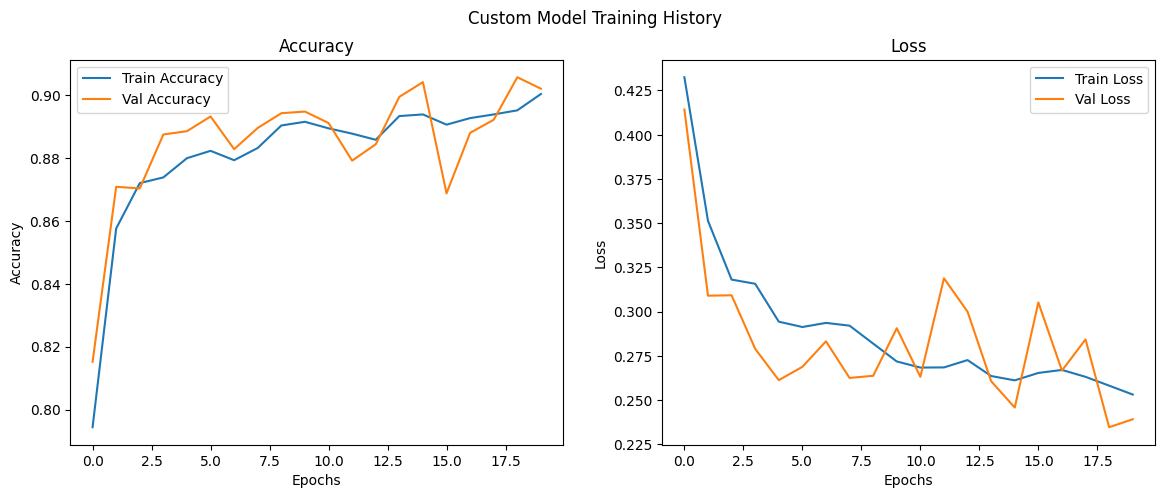

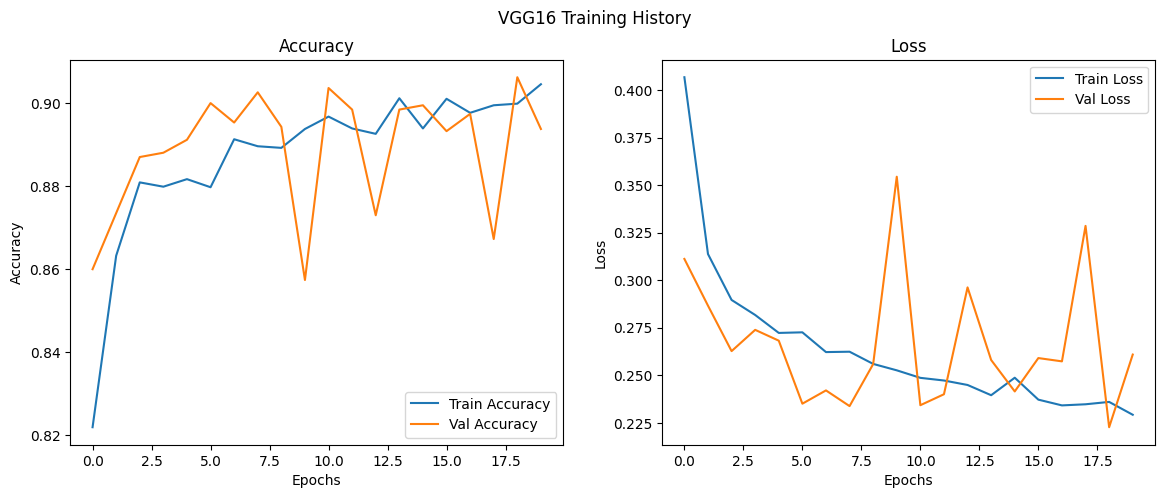

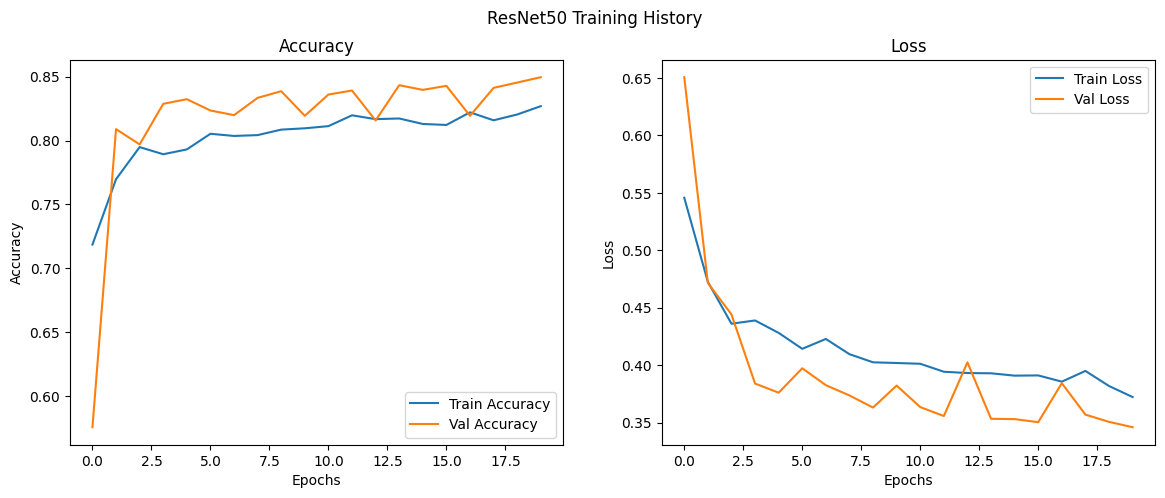

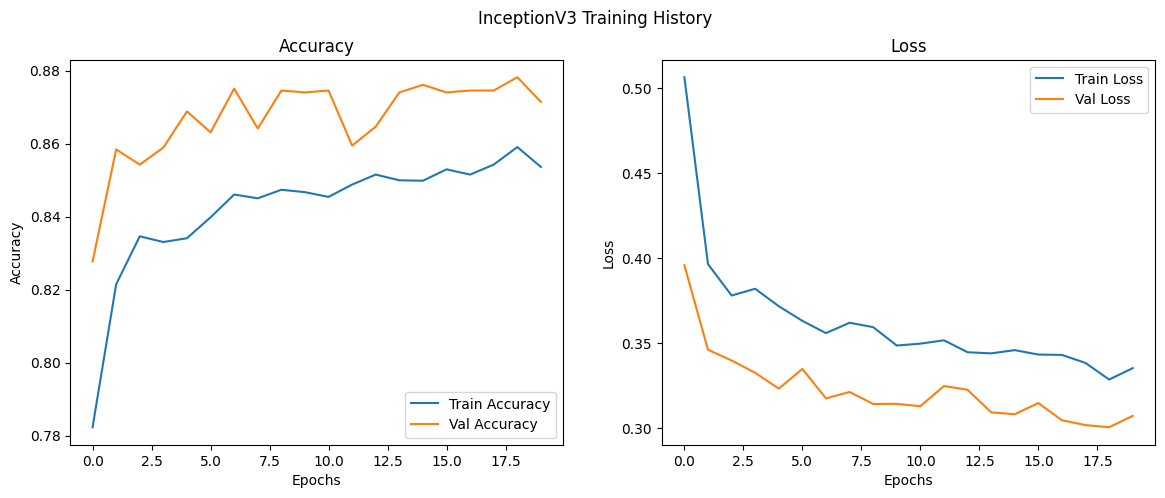

In [65]:
plot_history(custom_history, "Custom Model Training History")
plot_history(vgg16_history, "VGG16 Training History")
plot_history(resnet_history, "ResNet50 Training History")
plot_history(inception_history, "InceptionV3 Training History")

## Test-Set Accuracy

The `evaluate_model` function evaluates a model on a test dataset, printing the test loss and accuracy, and returns a dictionary containing the model's name and test accuracy for easy comparison.

In [66]:
def evaluate_model(model, model_name, test_generator):
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    print(f"{model_name} Test Loss: {loss:.4f}")
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    return {"Model": model_name, "Test Accuracy": accuracy}

In [67]:
# List of models to evaluate
models_list = [
    ("Custom Model", custom_cnn_model),
    ("VGG16", vgg16_model),
    ("ResNet50", resnet_model),
    ("InceptionV3", inception_model)
]

# Evaluate each model
results = []
for model_name, model in models_list:
    result = evaluate_model(model, model_name, test_generator)
    results.append(result)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9355 - loss: 0.1887
Custom Model Test Loss: 0.2268
Custom Model Test Accuracy: 0.9130
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9554 - loss: 0.1585
VGG16 Test Loss: 0.2393
VGG16 Test Accuracy: 0.9130
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8996 - loss: 0.2735
ResNet50 Test Loss: 0.2699
ResNet50 Test Accuracy: 0.8880
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9041 - loss: 0.2613
InceptionV3 Test Loss: 0.2623
InceptionV3 Test Accuracy: 0.8950


In [68]:
results_df = pd.DataFrame(results)
print("\nTest Accuracy Summary:")
print(results_df)


Test Accuracy Summary:
          Model  Test Accuracy
0  Custom Model          0.913
1         VGG16          0.913
2      ResNet50          0.888
3   InceptionV3          0.895


## Classification Report

The `evaluate_classification` function evaluates a classification model by predicting the class labels on the test dataset and generating a classification report. It prints the precision, recall, and F1-score for each class (Benign and Malignant in this case). The model's predictions are thresholded at 0.5 to classify the outputs as 0 (Benign) or 1 (Malignant).

In [69]:
def evaluate_classification(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int)

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

In [70]:
for model_name, model in models_list:
    evaluate_classification(model, test_generator, model_name)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Classification Report for Custom Model:
              precision    recall  f1-score   support

      Benign       0.89      0.95      0.92       500
   Malignant       0.94      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

Classification Report for VGG16:
              precision    recall  f1-score   support

      Benign       0.86      0.98      0.92       500
   Malignant       0.98      0.85      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

      Benign       0.88      0.89      0.89       500
   M

## Confusion Matrix

The `plot_confusion_matrices` function generates and displays confusion matrices for multiple models. It evaluates each model on a test dataset, calculates the confusion matrix, and then plots it using `seaborn` for a side-by-side comparison. The resulting plot shows the model's performance in predicting "Benign" and "Malignant" classes.

In [71]:
def plot_confusion_matrices(models_list, test_generator):

    # Prepare subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()  

    for i, (model_name, model) in enumerate(models_list):
        y_true = test_generator.classes
        y_pred = (model.predict(test_generator) > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
        axes[i].set_title(f"Confusion Matrix: {model_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


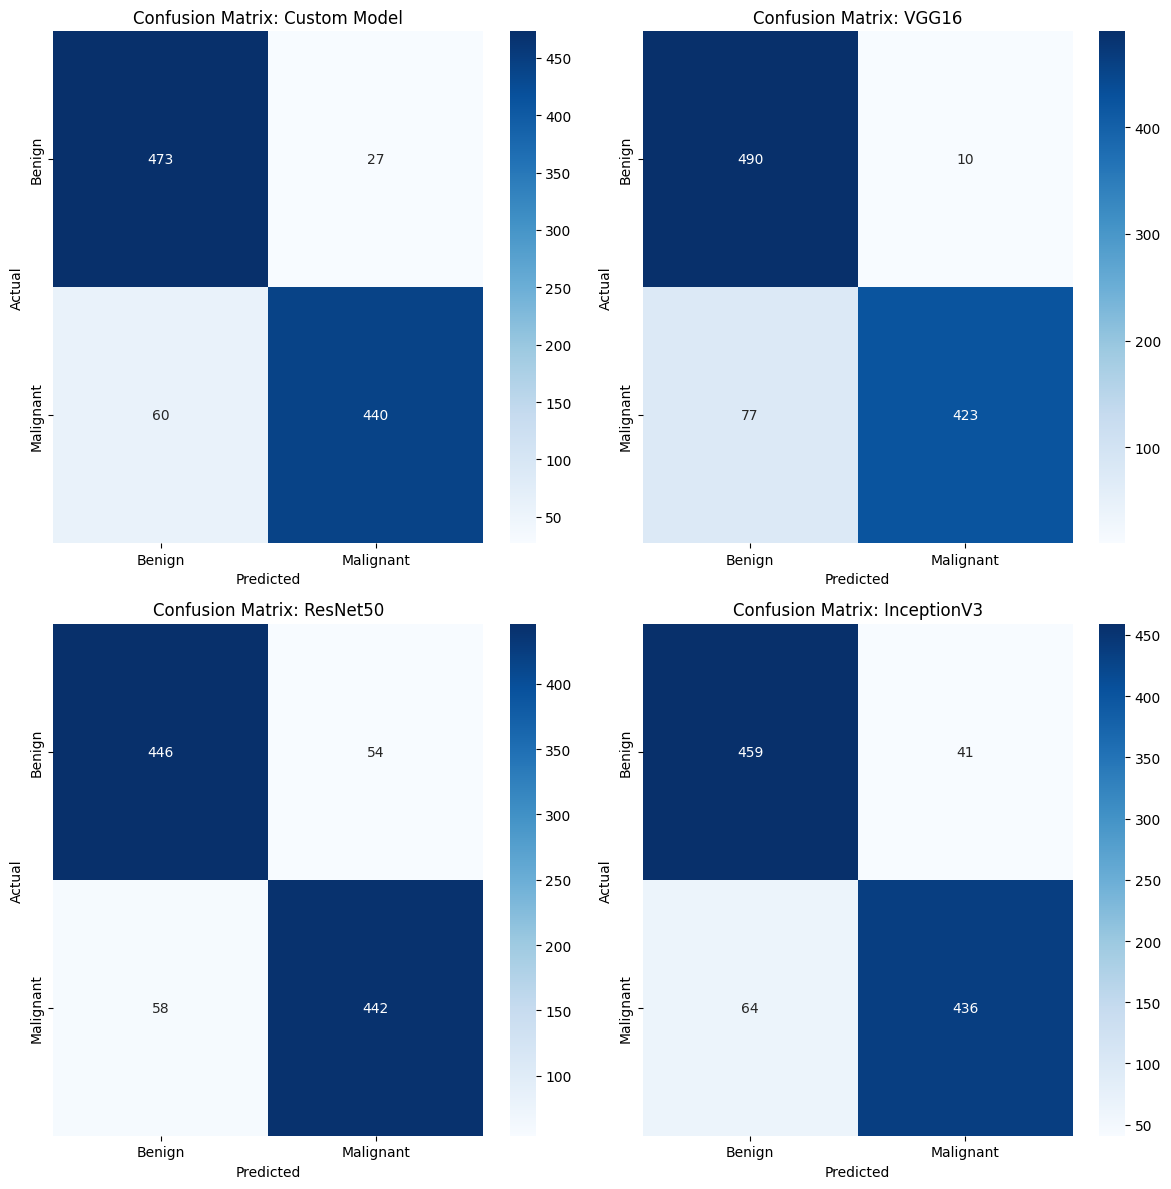

In [72]:
plot_confusion_matrices(models_list, test_generator)

# Hypothesis Testing

--------------------------

The `train_and_evaluate` function trains a model on the training data, validates it, and then evaluates it on the test data. It returns the model's accuracy on the test set after completing the specified number of epochs.

In [73]:
def train_and_evaluate(model, train_generator, val_generator, test_generator, epochs=EPOCHS):

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
    loss, accuracy = model.evaluate(test_generator, verbose=0)
    return accuracy


## Augmentation vs No-Augmentation

The code runs 3 iterations to train and evaluate two models: one with data augmentation (`model_aug`) and one without (`model_no_aug`). It tracks the accuracy for both models across each run and prints the results at the end to compare their performance.

In [74]:
accuracy_with_aug = []
accuracy_without_aug = []

num_runs = 3

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")

    model_aug = build_final_custom_cnn()
    model_no_aug = build_final_custom_cnn()

    model_aug.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)
    model_no_aug.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)

    acc_aug = train_and_evaluate(model_aug, train_generator, val_generator, test_generator)
    acc_no_aug = train_and_evaluate(model_no_aug, train_generator_no_aug, val_generator, test_generator)

    accuracy_with_aug.append(acc_aug)
    accuracy_without_aug.append(acc_no_aug)

# Print accuracy results
print("\nAccuracy with Augmentation:", accuracy_with_aug)
print("Accuracy without Augmentation:", accuracy_without_aug)


Run 1/3
Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.7171 - loss: 0.5469 - val_accuracy: 0.8532 - val_loss: 0.3733
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.8459 - loss: 0.3596 - val_accuracy: 0.8699 - val_loss: 0.3067
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.8654 - loss: 0.3340 - val_accuracy: 0.8678 - val_loss: 0.3159
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.8746 - loss: 0.3134 - val_accuracy: 0.8730 - val_loss: 0.3120
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8656 - loss: 0.3229 - val_accuracy: 0.8798 - val_loss: 0.2914
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7370 - loss: 0.5416 - val_accuracy: 0.8730 - val_loss: 0.3116
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8681 - loss: 0.3109 - val_accuracy: 0.8464 - val_loss: 0.3399
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8730 - loss: 0.3031 - val_accuracy: 0.8756 - val_loss: 0.2765
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8881 - loss: 0.2712 - val_accuracy: 0.8693 - val_loss: 0.3088
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8911 - loss: 0.2631 - val_accuracy: 0.8948 - val_loss: 0.2591

Run 2/3
Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.8490 - val_loss: 0.3469
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8572 - loss: 0.3427 - val_accuracy: 0.8709 - val_loss: 0.3171
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8743 - loss: 0.3194 - val_accura

## T-Test Result

The code performs a paired t-test to compare the accuracy of models with and without data augmentation. It checks whether the difference in performance is statistically significant by comparing the p-value to a significance level (alpha = 0.05). If the p-value is less than alpha, it concludes that data augmentation significantly improves model performance; otherwise, it finds no significant improvement.

In [2]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t_stat, p_value = ttest_rel(accuracy_with_aug, accuracy_without_aug)

alpha = 0.05

print("\nHypothesis Test Results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("\nReject the null hypothesis: Data augmentation significantly improves model performance!")
else:
    print("\nFail to reject the null hypothesis: No significant improvement from data augmentation.")



Hypothesis Test Results:
t-statistic: -0.7078
p-value: 0.5524

Fail to reject the null hypothesis: No significant improvement from data augmentation.
